In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os


os.environ["TOKENIZERS_PARALLELISM"] = "false"


import safe as sf
import datamol as dm


Load the default pretrained Safe model.

We will use this unique model for all the downstream molecular design tasks.


In [3]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model


/Users/emmanuel.noutahi/miniconda3/envs/safe/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)


Let's start with the below molecule.


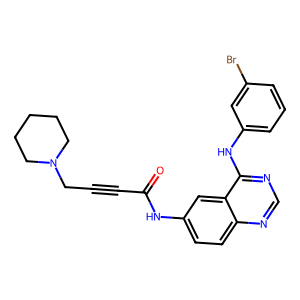

In [4]:
candidate_smiles = "O=C(C#CCN1CCCCC1)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1"
candidate_mol = dm.to_mol(candidate_smiles)

dm.to_image(candidate_mol)


## De novo generation

Generation of novel molecules without any constraints.


In [5]:
generated_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=12)

generated_smiles[:5]


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/emmanuel.noutahi/miniconda3/envs/safe/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/emmanuel.noutahi/miniconda3/envs/safe/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2024-09-11 15:59:20.886 | INFO     | safe.sample:de_novo_generation:755 - After sanitization, 11 / 12 (91.67 %) generated molecules are valid !


['CC(C)(C)NC(=O)N1CC[NH+](Cc2cccc(SC(F)(F)F)c2)CC1',
 'Cc1nc(C2CC2)ccc1C(=O)O[C@@H](C)C(=O)c1ccc(CC(C)C)cc1',
 'C[NH+]1Cc2ccccc2[C@H]1C(=O)NCCc1nnc2ccc(C(F)(F)F)cn12',
 'C[NH+]1CCC[C@]2(CCC[NH+](C[C@@H]3CCC=CO3)C2)C1',
 'Cc1nscc1C(=O)N1CC[C@@H](CNc2ccnc(C#N)n2)C1']

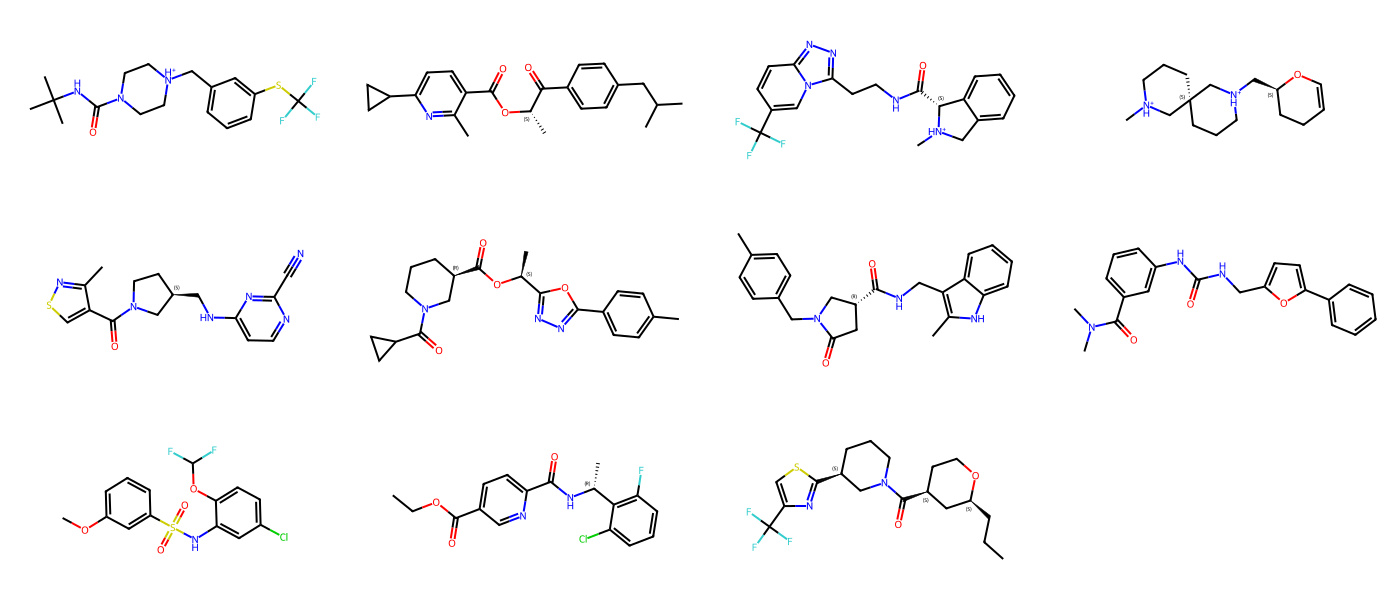

In [6]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Scaffold Decoration

For scaffold decoration, we wish to generate new molecules that would contain a given scaffold as core. Usually, the attachment point on the scaffold should dictate where the new vectors will be added.


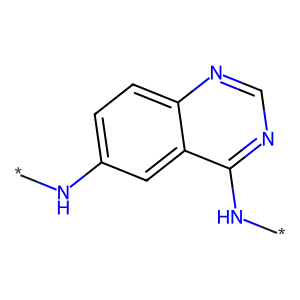

In [7]:
scaffold = "[*]N-c1ccc2ncnc(-N[*])c2c1"

dm.to_image(scaffold)


In [8]:
generated_smiles = designer.scaffold_decoration(
    scaffold=scaffold,
    n_samples_per_trial=12,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=True,
)

generated_mols = [dm.to_mol(x) for x in generated_smiles]


  0%|          | 0/2 [00:00<?, ?it/s]

2024-09-11 15:59:35.121 | INFO     | safe.sample:scaffold_decoration:635 - After sanitization, 23 / 24 (95.83 %)  generated molecules are valid !


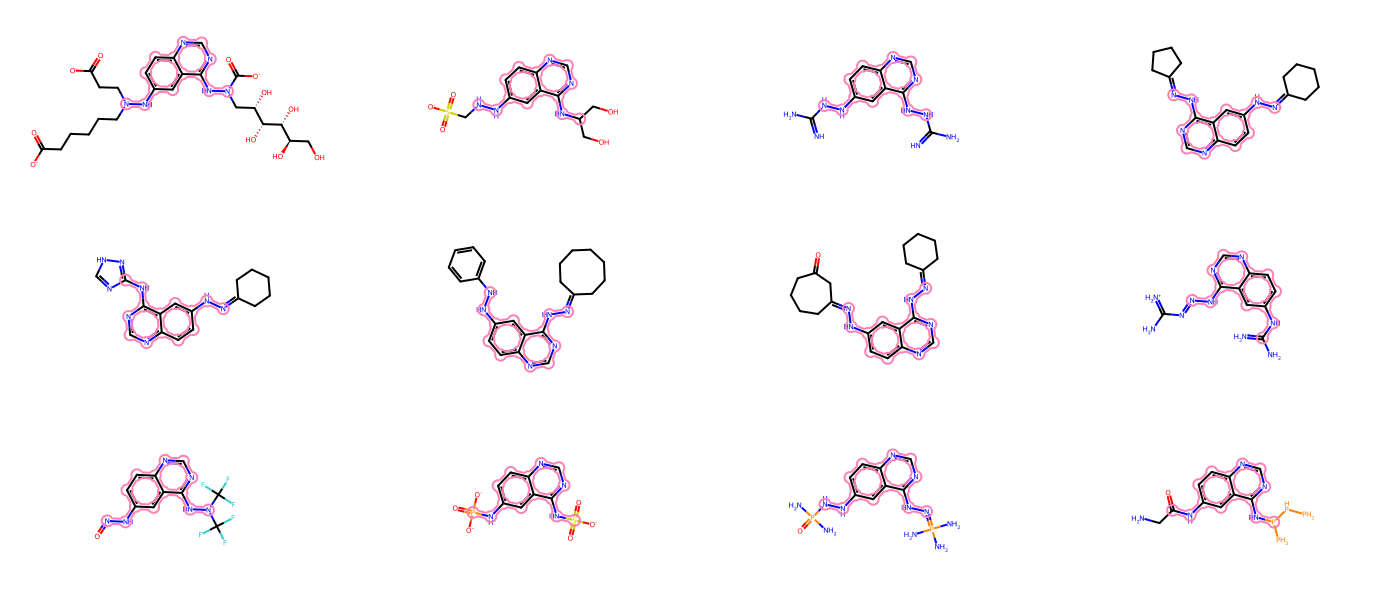

In [9]:
dm.viz.lasso_highlight_image(generated_mols[:12], dm.from_smarts(scaffold), mol_size=(350, 200), color_list=["#ff80b5"], scale_padding=0.1)


## Pattern decoration

For pattern decoration, we wish to generate new molecules that would contain a given molecular pattern expressed as a SMARTS. [SMARTS](https://daylight.com/dayhtml/doc/theory/theory.smarts.html) are different from scaffolds as they allow allows "rules" for matching several atoms and bonds simultaneously. In SAFE, the pattern decoration only supports a subset of the SMARTS specification. We recommend filtering generated compounds after to preserve your specifc input patterns. Alternatively, you can use the `sanitize` input.

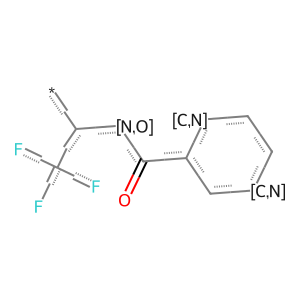

In [10]:
patterns = "FC(F)(F)C(*)[N,#8]C(=O)c1[c,n]cc[c,n]c1"
dm.to_image(dm.from_smarts(patterns))

/Users/emmanuel.noutahi/miniconda3/envs/safe/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:28:28.583 | ERROR    | safe.sample:_completion:927 - Python argument types in
    rdkit.Chem.rdmolops.FindPotentialStereo(NoneType)
did not match C++ signature:
    FindPotentialStereo(RDKit::ROMol {lvalue} mol, bool cleanIt=False, bool flagPossible=True)


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:28:28.588 | ERROR    | safe.sample:_completion:927 - Python argument types in
    rdkit.Chem.rdmolops.FindPotentialStereo(NoneType)
did not match C++ signature:
    FindPotentialStereo(RDKit::ROMol {lvalue} mol, bool cleanIt=False, bool flagPossible=True)


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/emmanuel.noutahi/miniconda3/envs/safe/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:28:29.287 | ERROR    | safe.sample:_completion:927 - Python argument types in
    rdkit.Chem.rdmolops.FindPotentialStereo(NoneType)
did not match C++ signature:
    FindPotentialStereo(RDKit::ROMol {lvalue} mol, bool cleanIt=False, bool flagPossible=True)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:28:30.851 | ERROR    | safe.sample:_completion:927 - Python argument types in
    rdkit.Chem.rdmolops.FindPotentialStereo(NoneType)
did not match C++ signature:
    FindPotentialStereo(RDKit::ROMol {lvalue} mol, bool cleanIt=False, bool flagPossible=True)


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:28:30.855 | ERROR    | safe.sample:_completion:927 - Python argument types in
    rdkit.Chem.rdmolops.FindPotentialStereo(NoneType)
did not match C++ signature:
    FindPotentialStereo(RDKit::ROMol {lvalue} mol, bool cleanIt=False, bool flagPossible=True)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:28:33.019 | ERROR    | safe.sample:_completion:927 - Python argument types in
    rdkit.Chem.rdmolops.FindPotentialStereo(NoneType)
did not match C++ signature:
    FindPotentialStereo(RDKit::ROMol {lvalue} mol, bool cleanIt=False, bool flagPossible=True)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:28:36.471 | ERROR    | safe.sample:_completion:927 - Python argument types in
    rdkit.Chem.rdmolops.FindPotentialStereo(NoneType)
did not match C++ signature:
    FindPotentialStereo(RDKit::ROMol {lvalue} mol, bool cleanIt=False, bool flagPossible=True)


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:28:36.475 | ERROR    | safe.sample:_completion:927 - Python argument types in
    rdkit.Chem.rdmolops.FindPotentialStereo(NoneType)
did not match C++ signature:
    FindPotentialStereo(RDKit::ROMol {lvalue} mol, bool cleanIt=False, bool flagPossible=True)


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:28:46.773 | INFO     | safe.sample:pattern_decoration:717 - After sanitization, 24 / 50 (48.00%) generated molecules are valid!


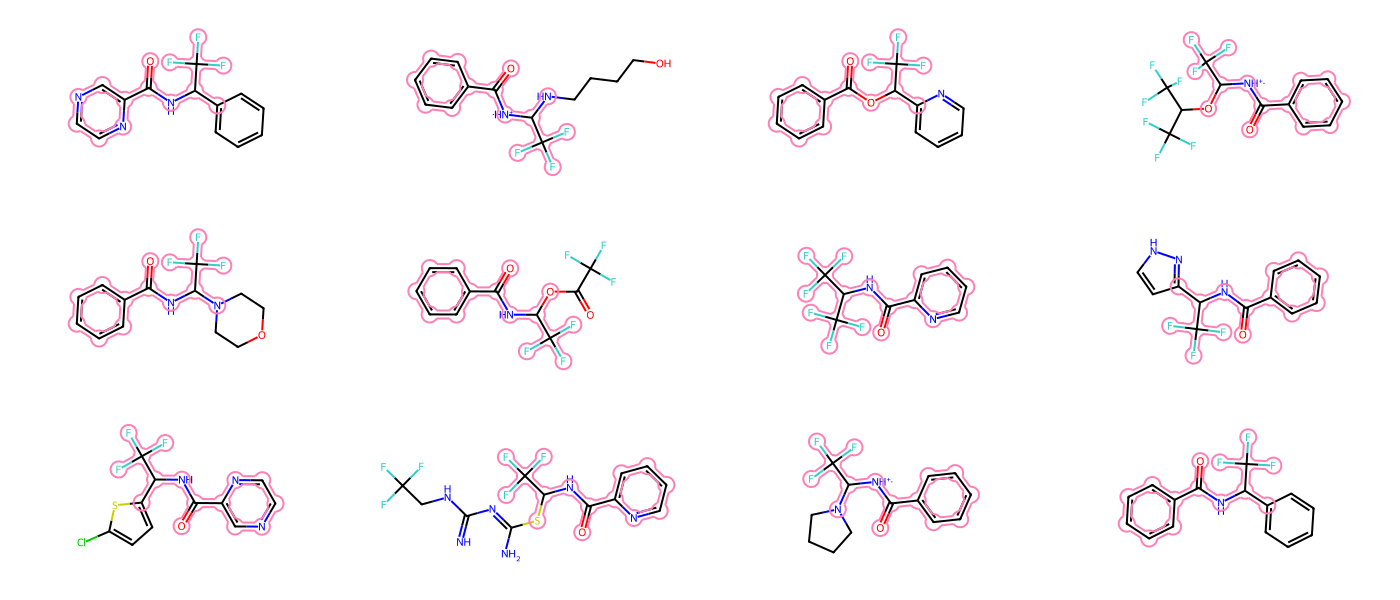

In [25]:
generated_smiles = designer.pattern_decoration(patterns,
    n_samples_per_trial=50,
    n_trials=1,
    sanitize=True,
    n_scaff_samples=10,
    n_scaff_random=5,
    do_not_fragment_further=True,
)
    
generated_mols = [dm.to_mol(x) for x in generated_smiles]
dm.viz.lasso_highlight_image(generated_mols[:12], dm.from_smarts(patterns), mol_size=(350, 200), color_list=["#ff80b5"], scale_padding=0.1)


## Super structure generation

In super structure generation, we just want to generate superstructure of a molecular subgraph


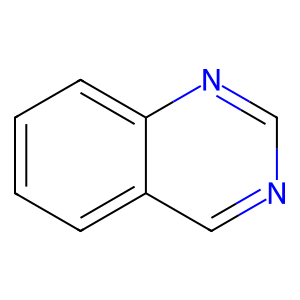

In [12]:
superstructure = "c1ccc2ncncc2c1"

dm.to_image(superstructure)


In [13]:
generated_smiles = designer.super_structure(
    core=superstructure,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    attachment_point_depth=3,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 15:59:51.548 | INFO     | safe.sample:super_structure:589 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['N#Cc1ncc2cc([N+](=O)[O-])cc(C#N)c2n1',
 'OCc1cc(C(F)(F)F)cc2cnc(OC(F)(F)F)nc12',
 'O=C([O-])c1cc(C(F)(F)F)c2nc(C(F)(F)F)ncc2c1',
 'N#Cc1cc([N+](=O)[O-])c2nc(C(=O)[O-])ncc2c1',
 'NCCS(=O)(=O)c1cc(C(F)(F)F)cc2cnc([N+](=O)[O-])nc12',
 'NC(=O)c1cc(C(N)=O)c2nc(NCCCCCO)ncc2c1',
 'NS(=O)(=O)c1cc([N+](=O)[O-])cc2cnc([N+](=O)[O-])nc12',
 'NC(=O)c1cc(CO)cc2cnc(NC(=O)C=CC(=O)[O-])nc12',
 'N#Cc1cc(C#N)c2nc(C(F)(F)C(F)(F)F)ncc2c1',
 'N#Cc1cc(C#N)c2nc(C(F)(F)C(F)(F)F)ncc2c1',
 'OC[C@H](CC(F)(F)F)Nc1ncc2cc(C(F)(F)F)cc(C(F)(F)F)c2n1',
 'N#Cc1cc(C#N)c2nc(C(F)(F)C(F)(F)C(F)(F)F)ncc2c1']

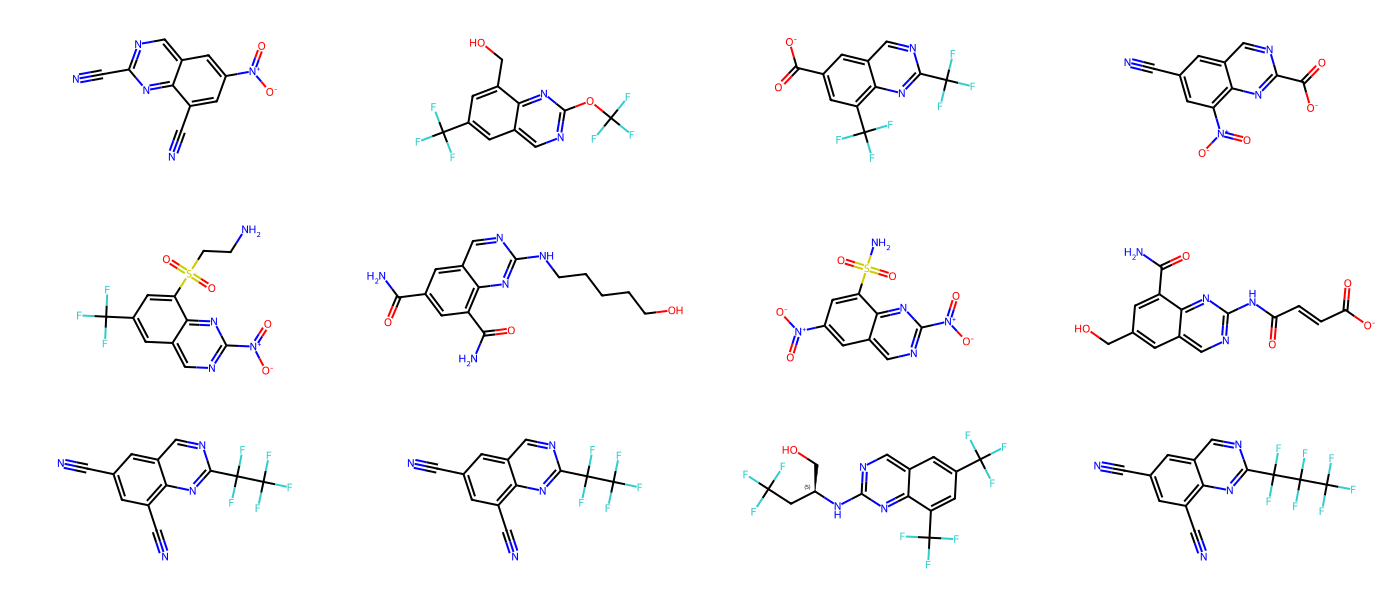

In [14]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Motif Extension

In motif extension, we are interested in generating a molecule containing a given motif as starting point.


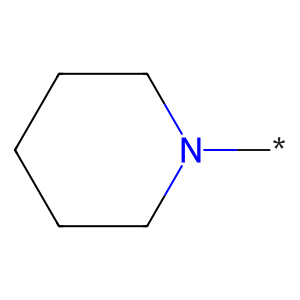

In [15]:
motif = "[*]-N1CCCCC1"

dm.to_image(motif)


In [16]:
# let's make some long sequence
generated_smiles = designer.motif_extension(
    motif=motif,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    min_length=25,
    max_length=80,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 15:59:54.387 | INFO     | safe.sample:scaffold_decoration:635 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['C1CCN(C2CO2)CC1.CN=C(C)O.CO.CO',
 'Fn1cccc1.S=C=NCCCN1CCCCC1',
 'N[C@H](CCCCCCC(=O)N1CCCCC1)C(F)(F)F',
 'C1CCCN(CCCN2CCCCC2)CC1',
 'C1CCN(CC2CCN2)CC1.Cl.Cl',
 'CCCCCCCCCCCCCCC1=C(O)CC(CCCCCCCCCCCCCCCCNC)CC1=O.N#CCN1CCCCC1',
 'N#CC(C(=O)N1CCCCC1)=C(O)CCCC(=O)[O-]',
 'O=C(CCC(F)(F)F)OCCCNC(=O)N1CCCCC1',
 'O=C([O-])C=CC[S@+]([O-])CCC(=O)N1CCCCC1',
 'O=C([O-])CCCCCCCNS(=O)(=O)CCC(=O)N1CCCCC1',
 'C1CCN(C2CCCOC2)CC1.Cl.O=P(O)(O)O',
 'NC(=O)CCCCC(=O)N1CCCCC1']

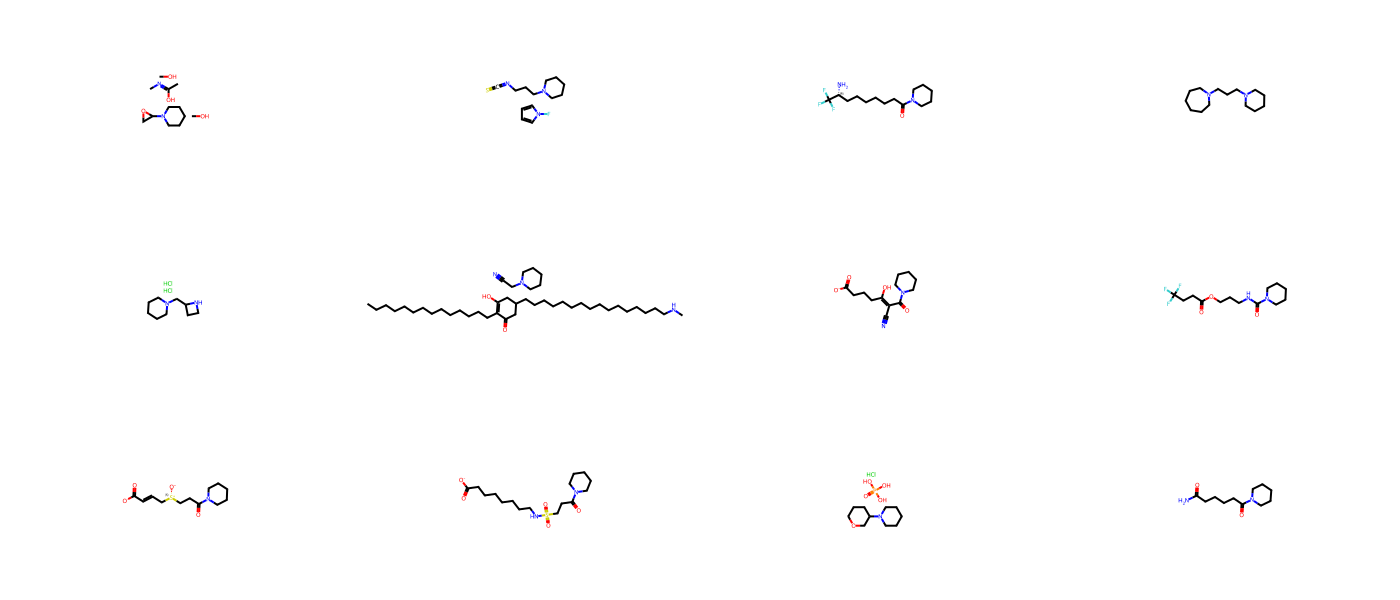

In [17]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Scaffold Morphing

In scaffold morphing, we wish to replace a scaffold by another one in a molecule. The process requires as input that the user provides either the side chains or the input molecules and the core


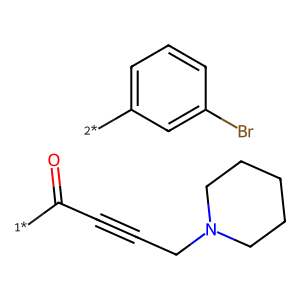

In [18]:
side_chains = "[1*]C(=O)C#CCN1CCCCC1.[2*]c1cccc(Br)c1"

dm.to_image(side_chains)


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 15:59:57.753 | INFO     | safe.sample:_fragment_linking:490 - After sanitization, 6 / 12 (50.00 %)  generated molecules are valid !


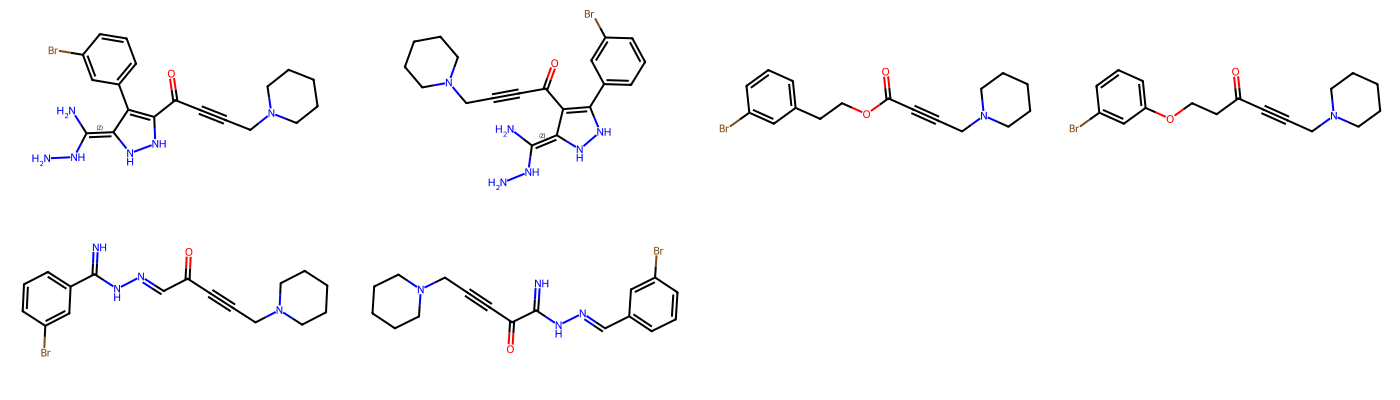

In [19]:
generated_smiles = designer.scaffold_morphing(
    side_chains=side_chains,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Linker generation

Linker generation is mostly the same thing as scaffold morphing ...


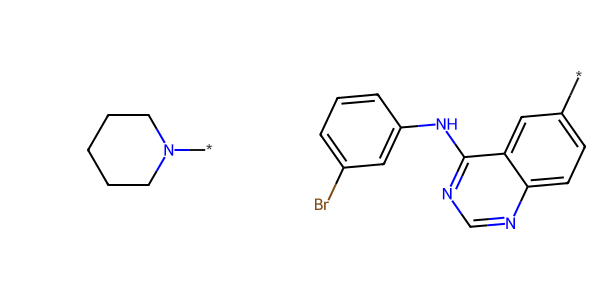

In [20]:
linker_generation = ["[*]-N1CCCCC1", "Brc1cccc(Nc2ncnc3ccc(-[*])cc23)c1"]

dm.to_image(linker_generation)


In [21]:
generated_smiles = designer.linker_generation(
    *linker_generation,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-11 16:00:02.509 | INFO     | safe.sample:_fragment_linking:490 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['Brc1cccc(Nc2ncnc3ccc(CC4CCNCC(N5CCCCC5)C4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(C4CNCCC(CN5CCCCC5)C4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(C4CCN(N5CCCCC5)C4NC4CC4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(N4CCC(N5CCCCC5)C4NC4CC4)cc23)c1',
 'O=S(=O)(c1cccnc1)c1c(N=NN2CCCCC2)cnc2c(-c3ccc4ncnc(Nc5cccc(Br)c5)c4c3)noc12',
 'O=S(=O)(c1cccnc1)c1c(N=Nc2ccc3ncnc(Nc4cccc(Br)c4)c3c2)cnc2c(N3CCCCC3)noc12',
 'Brc1cccc(Nc2ncnc3ccc(-c4ccc5nc(N6CCCCC6)[nH]c5c4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4nc5ccc(N6CCCCC6)cc5[nH]4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(C4CCC(N5CCCCC5)CC4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(C4CCC(N5CCCCC5)CC4)cc23)c1',
 'O=C(NC1CCC2C(CCCCCCCCC2c2ccc3ncnc(Nc4cccc(Br)c4)c3c2)C1)C(=O)N1CCC(N2CCCCC2)CC1',
 'O=C(NC1CCC2C(CCCCCCCCC2N2CCCCC2)C1)C(=O)N1CCC(c2ccc3ncnc(Nc4cccc(Br)c4)c3c2)CC1']

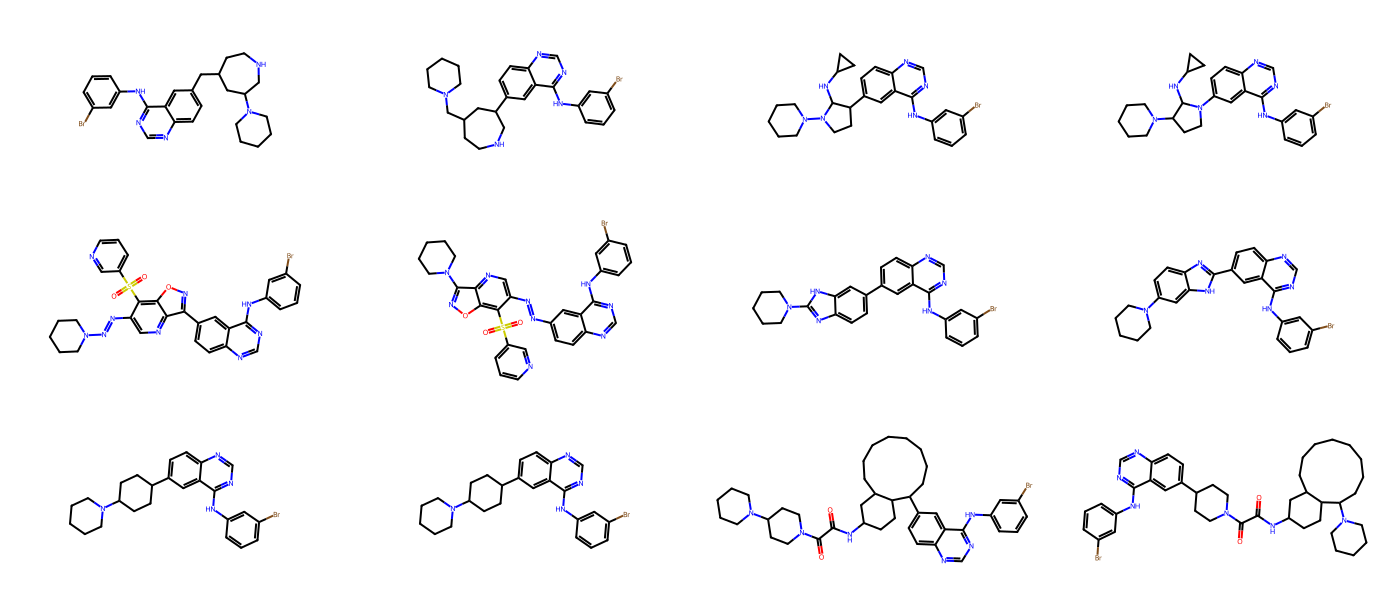

In [22]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


---

The End !